In [1]:
### 03_RegimeDetection.ipynb
# Objective: Detect market regimes using ML models (clustering + supervised), based on entropy & volatility features.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os
import joblib


In [2]:
# ----------------------------
# Step 1: Load Feature Data
# -----------------------------
data = pd.read_csv("../data/processed/feature_matrix.csv", index_col=0, parse_dates=True)

# Feature columns only (exclude any existing targets)
X = data.copy()

In [3]:
# ----------------------------
# Step 2: Volatility-based Regime Labels
# ----------------------------
# We'll take average realized volatility across sectors as a proxy
vol_cols = [col for col in data.columns if '_real_vol' in col]
data['avg_real_vol'] = data[vol_cols].mean(axis=1)

# Define volatility regimes using percentiles
thresh1 = np.percentile(data['avg_real_vol'], 33)
thresh2 = np.percentile(data['avg_real_vol'], 66)

def label_vol_regime(v):
    if v < thresh1:
        return 0  # Low Vol
    elif v < thresh2:
        return 1  # Medium Vol
    else:
        return 2  # High Vol

data['vol_regime'] = data['avg_real_vol'].apply(label_vol_regime)

# Save volatility regimes
data[['vol_regime']].to_csv("../data/processed/volatility_regimes.csv")


In [4]:
# ----------------------------
# Step 3: Preprocessing & PCA
# ----------------------------

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
import numpy as np

# Handle inf and NaN values via forward- and backward-fill
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(method='ffill', inplace=True)
X.fillna(method='bfill', inplace=True)




C:\Users\iamta\AppData\Local\Temp\ipykernel_14352\2861452761.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method='ffill', inplace=True)
C:\Users\iamta\AppData\Local\Temp\ipykernel_14352\2861452761.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method='bfill', inplace=True)


In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "../scripts/models/scaler.joblib")

# PCA to 2D for clustering
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_scaled)
print("PCA explained variance ratio:", pca.explained_variance_ratio_)


PCA explained variance ratio: [0.16610698 0.07380539 0.07271834 0.04762788 0.04033617 0.04015382
 0.03527504 0.03335359 0.02907752 0.02865374 0.02752401 0.0260065
 0.02439887 0.02373055 0.02234929 0.02168906 0.02032619 0.01958103
 0.01930482 0.0179482 ]


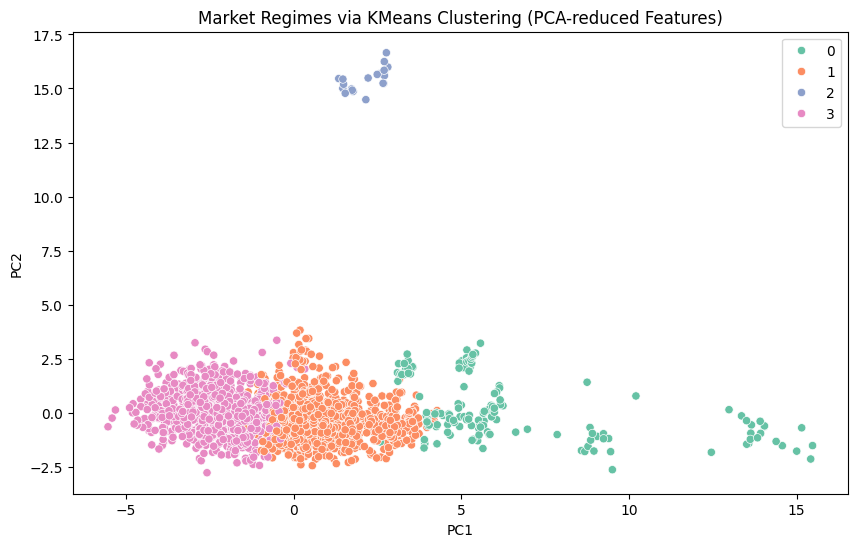

In [17]:
# ----------------------------
# Step 4: Unsupervised Regime Detection (KMeans)
# ----------------------------
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

# Save cluster regimes
data['cluster_regime'] = kmeans_labels

# ----------------------------
# Step 5: Visualize Clusters
# ----------------------------
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='Set2')
plt.title("Market Regimes via KMeans Clustering (PCA-reduced Features)")
plt.xlabel("PC1")
plt.ylabel("PC2")
#plt.savefig("../results/plots/regime_clusters_pca.png")
plt.show()

In [19]:
# ----------------------------
# Step 6: Supervised Regime Classifier
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, data['vol_regime'], test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Classification Report for Volatility Regimes:")
print(classification_report(y_test, y_pred))

joblib.dump(clf, "../scripts/models/vol_regime_rf_model.joblib")


Classification Report for Volatility Regimes:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       152
           1       0.94      0.96      0.95       143
           2       0.99      0.99      0.99       147

    accuracy                           0.97       442
   macro avg       0.97      0.97      0.97       442
weighted avg       0.97      0.97      0.97       442



['../scripts/models/vol_regime_rf_model.joblib']

In [20]:
!pip install xgboost



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, data['vol_regime'], test_size=0.2, random_state=42)

# Initialize and fit XGBoost model
xgb_clf = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_clf.predict(X_test)

# Evaluation
print("Classification Report for Volatility Regimes (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

# Save model
joblib.dump(xgb_clf, "../scripts/models/vol_regime_xgb_model.joblib")


c:\Users\iamta\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:46:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report for Volatility Regimes (XGBoost):
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       152
           1       0.96      0.98      0.97       143
           2       1.00      0.99      1.00       147

    accuracy                           0.98       442
   macro avg       0.98      0.98      0.98       442
weighted avg       0.98      0.98      0.98       442



['../scripts/models/vol_regime_xgb_model.joblib']

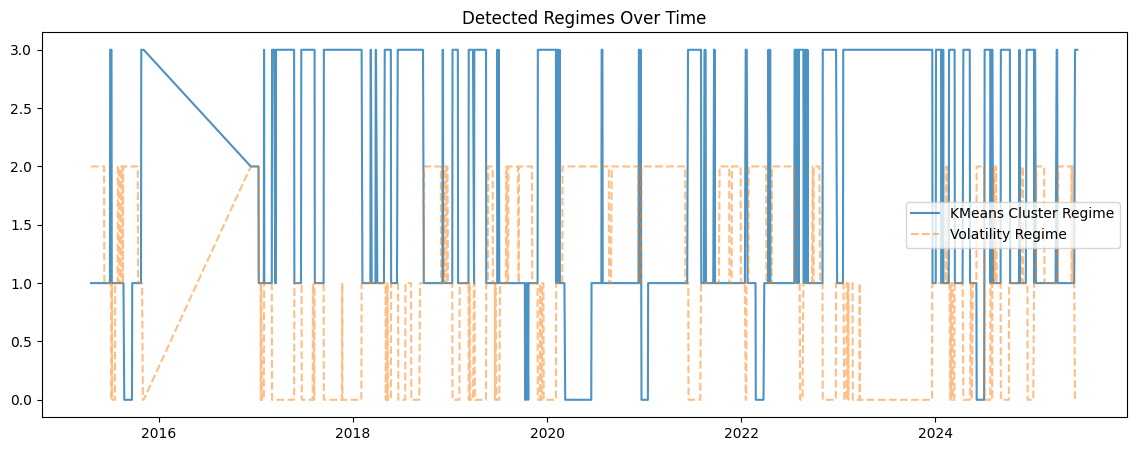

In [22]:
# ----------------------------
# Step 7: Regime Time Series
# ----------------------------
plt.figure(figsize=(14, 5))
plt.plot(data.index, data['cluster_regime'], label='KMeans Cluster Regime', alpha=0.8)
plt.plot(data.index, data['vol_regime'], label='Volatility Regime', linestyle='--', alpha=0.5)
plt.legend()
plt.title("Detected Regimes Over Time")
#plt.savefig("../results/plots/regime_timeseries.png")
plt.show()

# Save final regime labels
data[['vol_regime', 'cluster_regime']].to_csv("../data/processed/regime_labels.csv")


In [23]:
import numpy as np

# Mark inf as NaN
X_clean_check = X.replace([np.inf, -np.inf], np.nan)

# Count rows with any NaN (i.e., inf or missing)
rows_with_issues = X_clean_check.isna().any(axis=1).sum()

print(f"⚠️ Rows with inf/NaN values: {rows_with_issues} out of {len(X)}")


⚠️ Rows with inf/NaN values: 0 out of 2209


In [24]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

print("Adjusted Rand Index:", adjusted_rand_score(data['vol_regime'], data['cluster_regime']))
print("Normalized Mutual Information:", normalized_mutual_info_score(data['vol_regime'], data['cluster_regime']))


Adjusted Rand Index: 0.40796209639233
Normalized Mutual Information: 0.4741684714351017


In [25]:
regime_transitions = pd.crosstab(data['cluster_regime'].shift(), data['cluster_regime'])
regime_transitions = regime_transitions.div(regime_transitions.sum(axis=1), axis=0)
print(regime_transitions)


cluster_regime         0         1        2         3
cluster_regime                                       
0.0             0.952055  0.047945  0.00000  0.000000
1.0             0.005085  0.948305  0.00000  0.046610
2.0             0.000000  0.050000  0.95000  0.000000
3.0             0.001160  0.060325  0.00116  0.937355


In [26]:
regime_summary = X.copy()
regime_summary['regime'] = data['cluster_regime']
mean_per_regime = regime_summary.groupby('regime').mean()
display(mean_per_regime.T.head(10))  # Show top 10 features


regime,0,1,2,3
NIFTY_IT_shannon,-409.688094,-704.977676,-5.845772,-1022.444249
NIFTY_IT_perm,0.938731,0.934765,0.950293,0.943330
NIFTY_IT_sample,1.612415,2.004169,0.044479,2.223415
NIFTY_IT_real_vol,0.022205,0.013116,0.494853,0.009958
NIFTY_IT_zscore,0.049901,0.020481,0.000868,-0.050724
NIFTY_IT_skew,-0.347972,-0.081519,4.127844,0.207634
NIFTY_IT_kurt,0.632356,0.372476,15.044123,0.385203
NIFTY_BANK_shannon,-246.108758,-760.866418,-322.550871,-1375.343333
NIFTY_BANK_perm,0.951217,0.939955,0.969184,0.940547
NIFTY_BANK_sample,1.641647,2.165090,1.373259,2.139969


Text(0.5, 1.0, 'Cumulative Returns under Different Regimes')

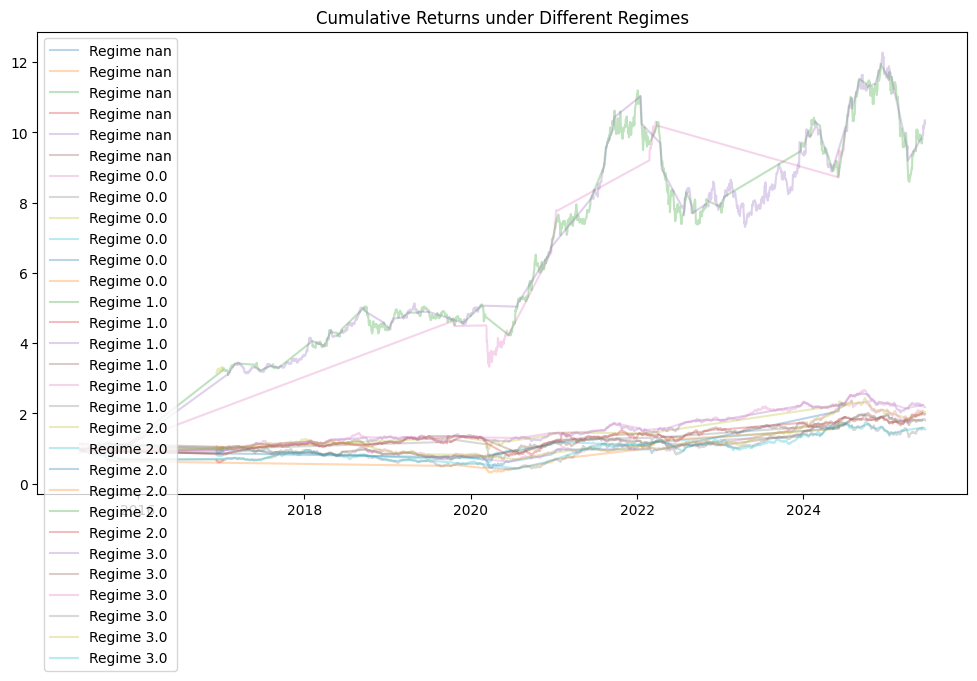

In [27]:
returns = pd.read_csv("../data/processed/returns_data.csv", index_col=0, parse_dates=True)
returns['regime'] = data['cluster_regime']

# Cumulative return per regime
cumulative = (1 + returns.drop(columns='regime')).cumprod()
regime_mask = returns['regime']

plt.figure(figsize=(12,6))
for r in sorted(regime_mask.unique()):
    plt.plot(cumulative[regime_mask == r], alpha=0.3, label=f"Regime {r}")
plt.legend()
plt.title("Cumulative Returns under Different Regimes")


In [28]:
pd.DataFrame(X_scaled, index=data.index, columns=X.columns).to_csv("../data/processed/X_scaled.csv")
data[['cluster_regime', 'vol_regime']].to_csv("../data/processed/regimes.csv")
